# NOTEBOOK NAME
Created by: Thomas Durand-Texte, 2023

# Import des packages et données
## import des packages

In [1]:
import os

import pickle
import time

import pandas as pd
import numpy as np
# import dask as dd
pd.set_option("display.max_columns", 200)
import datetime as dt
import scipy.stats as st

from sklearn import model_selection, metrics, preprocessing, linear_model, dummy

from sklearn.svm import LinearSVR, SVR
from sklearn import kernel_ridge
from sklearn.ensemble import RandomForestRegressor

import skops.io as sio # to save models

from lightgbm import LGBMRegressor


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

cm = 1./2.54

import shap
shap.initjs()

/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Paramètres graphiques et fonctions utiles

In [2]:
import subprocess

white_font = True
def set_theme( white_font=True ):
    """ set_theme( white_font=True ) """
    if white_font: wht, grey, blck = '0.84' , '0.5', 'k'
    else: wht, grey, blck = 'k', '0.5', '0.84'
    rc = { 'figure.facecolor':(0.118,)*3,
            'axes.labelcolor':wht,
            'axes.edgecolor':wht,
            'axes.facecolor':(0,0,0,0),
            'text.color':'white',
            'text.usetex':False,
            'text.latex.preamble':r'\usepackage[cm]{sfmath} \usepackage{amsmath}' ,
            'font.family': 'sans-serif' ,
            'font.sans-serif': 'DejaVu Sans' ,
            'xtick.color':wht,
            'ytick.color':wht,
            "axes.grid" : True,
            "grid.color": (0.7,)*3,
            "grid.linewidth": 0.4,
            "grid.linestyle": (10,5),
            'legend.edgecolor':'0.2',
            'legend.facecolor':(0.2,0.2,0.2,0.6),
            # 'legend.framealpha':'0.6',
            'pdf.fonttype':42,
            'savefig.format':'pdf',
            'savefig.transparent':True,
            'figure.dpi':150, # for better agreemet figsize vs real size
        }

    sns.set_theme( 'notebook' , rc=rc )
    return


def make_folder( path_folder ):
    path_folder = path_folder.__str__()
    try:
        if os.path.isdir( path_folder ) : return
        os.makedirs(path_folder)
    except OSError:
        pass
    return

def concat_folders(*args, **kwargs):
    """ concat_folders(*args, **kwargs)
        concatenate folders in args (strings) """
    sPath = ''
    for arg in args:
        if arg == '..': sPath = sPath[:sPath[:-1].rfind(os.sep)+1]
        else: sPath += arg
        if sPath[-1] != os.sep: sPath += os.sep
    return sPath

class Path(object):
    """ Path( s_in='', s_lim=None)
        create a path to the string s_in (default is current path)
        and stops after s_lim """
    n_Path = 0
    def __init__(self, s_in='', s_lim=None):
        """docstring."""
        if s_in == '': s_in = os.getcwd()
        if not s_lim is None:
            if s_lim in s_in:
                s_in = s_in[ :s_in.index( s_lim ) + len(s_lim) ]
        self.sPath = concat_folders(s_in)
        self.N = Path.n_Path
        Path.n_Path += 1

    def __add__(self, other):
        """ Path + str : return str """
        if isinstance(other, str): return self.sPath + other

    def __truediv__(self, other):
        """ Path / str : return path concatenated"""
        if isinstance(other, str): return Path(concat_folders(self.sPath, other))

    def __invert__(self):
        """ ~Path : return str of the path """
        return self.sPath

    def __str__(self):
        """ __str__ return str of the path """
        return self.sPath
    # __str__ #

    def makedir( self ):
        return make_folder( self )


def gs_opt( filename ):
    """ otpimisation of a pdf file with gosthscript """
    filenameTmp = filename.replace('.pdf', '') + '_tmp.pdf'
    gs = ['gs',
            '-sDEVICE=pdfwrite',
            '-dEmbedAllFonts=true',
            '-dSubsetFonts=true',             # Create font subsets (default)
            '-dPDFSETTINGS=/prepress',        # Image resolution
            '-dDetectDuplicateImages=true',   # Embeds images used multiple times only once
            '-dCompressFonts=true',           # Compress fonts in the output (default)
            '-dNOPAUSE',                      # No pause after each image
            '-dQUIET',                        # Suppress output
            '-dBATCH',                        # Automatically exit
            '-sOutputFile='+filenameTmp,      # Save to temporary output
            filename]                         # Input file

    subprocess.run(gs)                                      # Create temporary file
    subprocess.run( 'rm -f ' + filename, shell=True)            # Delete input file
    subprocess.run( 'mv -f ' + filenameTmp + " " + filename, shell=True) # Rename temporary to input file

def savefig( fig, savename, **kwargs ):
    """ savefig( fig, savename, **kwargs )
        Saves a figure with kwargs (fig.savefig( savename, **kwargs) ).
        A check is done first to determine if a folder has to be created according to savename.
        Finally, if the file is saved as .pdf, gosthscript optimisation is performed. """
    if os.sep in savename: make_folder( savename[:savename.rindex(os.sep)] )
    fig.savefig( savename, **kwargs )
    savename += '.pdf'
    if os.path.isfile( savename ): gs_opt( savename )


def image_size_from_width_and_shape( width: float, shape: tuple, ymargin=0. ):
    """ return tuple (width, height) corresponding to image shape """
    return width, width*shape[0]/shape[1]+ymargin

def image_size_from_height_and_shape( height: float, shape: tuple, xmargin=0. ):
    """ return tuple (width, height) corresponding to image shape """
    return height*shape[1]/shape[0]+xmargin, height


set_theme()
del set_theme

## Chargement des données

Affichage de l'arborescence

In [3]:
def print_listdir( path=None, level=0, exclude=[] ) :
    suffix = ''
    if level > 0:
        suffix = ' |-'* level
    vals = os.listdir( path )
    vals.sort()
    if path is None:
        path = ''
    for val in vals:
        if val in exclude: continue
        print( suffix, val)
        if os.path.isdir( path + val):
            print_listdir( path + val + '/', level+1 )

print_listdir( exclude=['.venv', 'ressources'] )

 Exploration_v0.ipynb
 Modelisation_energy (copy).ipynb
 Modelisation_energy.ipynb
 TODO
 data
 |- cleaned
 |- |- 2016_Building_Energy_Benchmarking.pkl
 |- |- 2016_Building_Energy_Benchmarking_annexe.pkl
 |- |- 2016_Building_Energy_Benchmarking_location.pkl
 |- |- 2016_Building_Energy_Benchmarking_usetype.pkl
 |- |- 2016_Building_Energy_Benchmarkingfeatures_log
 |- |- other_data.pkl
 |- models
 |- |- Xscaled
 |- |- |- dummy_median
 |- |- |- |- dict.pkl
 |- |- |- |- model.pkl
 |- |- |- |- transformer.pkl
 |- |- |- elastic_net
 |- |- |- |- dict.pkl
 |- |- |- |- model.pkl
 |- |- |- |- transformer.pkl
 |- |- |- kernel_SVR_rbf
 |- |- |- |- dict.pkl
 |- |- |- |- model.pkl
 |- |- |- |- transformer.pkl
 |- |- |- kernel_ridge_polynomial
 |- |- |- |- dict.pkl
 |- |- |- |- model.pkl
 |- |- |- |- transformer.pkl
 |- |- |- kernel_ridge_rbf
 |- |- |- |- dict.pkl
 |- |- |- |- model.pkl
 |- |- |- |- transformer.pkl
 |- |- |- light_GBM
 |- |- |- |- dict.pkl
 |- |- |- |- model.pkl
 |- |- |- |- transform

Chargement des données

In [4]:
path = 'data/cleaned/'
filename = '2016_Building_Energy_Benchmarking'
compression = 'gzip'

df = pd.read_pickle( r'{:}{:}.pkl'.format(path, filename), compression=compression )

df = pd.read_pickle( r'{:}{:}.pkl'.format(path, filename), compression=compression)
df_hotencoding_usetype = pd.read_pickle( r'{:}{:}_usetype.pkl'.format(path, filename), compression=compression)
df_hotencoding_location = pd.read_pickle( r'{:}{:}_location.pkl'.format(path, filename), compression=compression)
df_annexe = pd.read_pickle( r'{:}{:}_annexe.pkl'.format(path, filename), compression=compression)

with open( path + filename + 'features_log', 'rb') as file:
    features_log = pickle.load( file )

print('features_log:', features_log)
print('df:', df.shape)
print('df_hotencoding_usetype:', df_hotencoding_usetype.shape)
print('df_hotencoding_location:', df_hotencoding_location.shape)
print('df_annexe:', df_annexe.shape)
print('df columns:', df.columns.tolist())

features_log: ['NumberofBuildings', 'NumberofFloors', 'GFA_per_floor', 'sqrt_GFA_per_floor']
df: (1551, 13)
df_hotencoding_usetype: (1551, 18)
df_hotencoding_location: (1551, 13)
df_annexe: (1551, 12)
df columns: ['AgeOfBuilding(s)', 'CouncilDistrictCode', 'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'prop_SteamUse', 'prop_Electricity', 'prop_NaturalGas', 'GFA_per_floor', 'sqrt_GFA_per_floor', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissionsWN']


In [5]:
n_scale_X = 3
features_ordered = ['AgeOfBuilding(s)',
'Latitude', 'Longitude',
'NumberofBuildings', 'NumberofFloors',
'GFA_per_floor', 'sqrt_GFA_per_floor',
'prop_SteamUse', 'prop_Electricity', 'prop_NaturalGas',
'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissionsWN']
# 'CouncilDistrictCode',
df = df[features_ordered]
to_drop = [ 'TotalGHGEmissionsWN' ]

df.drop( columns=to_drop, inplace=True )



n_continuous = df.shape[1] -1

# df = pd.concat( (df, df_hotencoding_location, df_hotencoding_usetype), axis=1 )
df = pd.concat( (df, df_hotencoding_usetype), axis=1 )
print('df shape:', df.shape)

sr_loc = df.isna().sum(1) == 0

df = df.loc[ sr_loc, :]

target = 'SiteEnergyUseWN(kBtu)'
y = df[target]
df = df.drop( columns=target ).copy()

print('df shape:', df.shape)
print('y shape:', y.shape)


df.head()

df shape: (1551, 29)
df shape: (1551, 28)
y shape: (1551,)


,AgeOfBuilding(s),Latitude,Longitude,NumberofBuildings,NumberofFloors,GFA_per_floor,sqrt_GFA_per_floor,prop_SteamUse,prop_Electricity,prop_NaturalGas,ohe0 data center,ohe0 education,ohe0 entertainment - public assembly,ohe0 industrial,ohe0 lifestyle center,ohe0 medical,ohe0 medical office,ohe0 office,ohe0 other,ohe0 other - entertainment/public assembly,ohe0 residential - hotel,ohe0 restaurant,ohe0 science,ohe0 self-storage facility,ohe0 services,ohe0 store,ohe0 utility,ohe0 worship facility
0,89,47.61220,-122.33799,1,12,7369.500000,85.845792,0.277302,0.546060,0.176638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,20,47.61317,-122.33393,1,11,8045.636364,89.697471,0.000000,0.386609,0.613391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.947775,0.052225,0.0,0.0,0.0,0.0,0.0,0.0
2,47,47.61393,-122.33810,1,41,18521.756098,136.094659,0.297113,0.682307,0.020579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.996182,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,90,47.61412,-122.33664,1,10,6132.000000,78.307088,0.325913,0.407519,0.266567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,36,47.61375,-122.34047,1,18,6310.000000,79.435508,0.000000,0.378802,0.621198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.086855,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


## Transformer
<span style="color:red"> FAIRE UN TRANSFORMER AVEC PLUSIUERS MODES: </span>
- identiy
- log
- ... ?

In [6]:
GFA_ref = df_annexe['PropertyGFABuilding(s)']

<span style="color:red"> A GERER: </span>
> - Tranformer func save & load
> - obj = sio.dumps(clf)
> - unknown_types = sio.get_untrusted_types(obj)
> - clf = sio.loads(obj, trusted=unknown_types)
< - clf = sio.loads(obj, trusted=True)

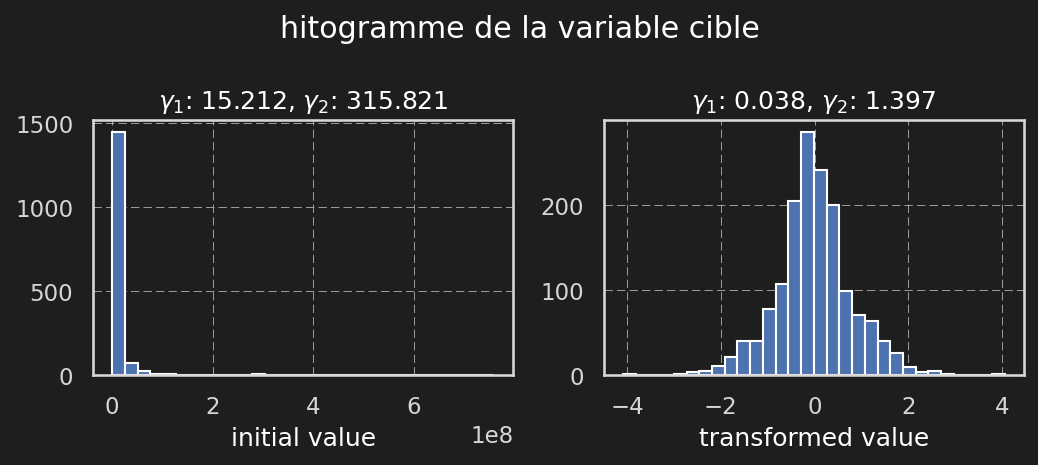

In [7]:
class Transformer:
    def __init__( self, type='identity', power=1, filename=None ):
        if filename is None:
            self.type = type
            self.cst = 0.
            self.y_min = 0.
        else:
            self.load( filename )
        # if type == 'power':
        #     self.power = power
        return
    def save( self, filename ):
        with open( filename, 'wb' ) as file:
            pickle.dump( (self.type, self.cst, self.y_min), file )
    def load( self, filename ):
        with open( filename, 'rb' ) as file:
            self.type, self.cst, self.y_min = pickle.load( file )
    def get_dico_func(self):
        return {'func':self.transform, 'inverse_func':self.reverse }
    def fit( self, y ):
        if self.type == 'identity':
            return self
        if self.type == 'log':
            self.y_min = 1 - min( y.min(), 0)
            self.cst = -np.log( y + self.y_min ).mean()
            return self
        # if self.type == 'loglog':
        #     self.y_min = 1 - min( y.min(), 0)
        #     self.cst = -np.log(np.log(y+self.y_min)).mean()
        #     return self
        # if self.type == 'power':
        #     self.y_min = 1 - min( y.min(), 0)
        #     self.cst = -((y+self.y_min)**self.power).mean()
        return self
    def transform( self, y ):
        if self.type == 'identity':
            return y
        # return (y+self.cst)**(1/6)
        # return y*self.coef + self.cst
        if self.type == 'log':
            return np.log( y + self.y_min ) + self.cst
        # if self.type == 'loglog':
        #     return np.log(np.log(y+self.y_min)) + self.cst
        # if self.type == 'power':
        #     return (y+self.y_min)**self.power + self.cst
    def inverse_transform( self, y ):
        if self.type == 'identity':
            return y
        # return -self.cst + y_transformed**6
        # return (y_transformed-self.cst) * ( 1./ self.coef )
        if self.type == 'log':
            return  np.exp( y - self.cst ) - self.y_min
        # if self.type == 'loglog':
        #     return np.exp(np.exp( y-self.cst )) - self.y_min
        # if self.type == 'power':
        #     return (y-self.cst)**(1./self.power) - self.y_min

# dict_transformer = Transformer(y).get_dico_func()
# transformer = preprocessing.FunctionTransformer( check_inverse=True, **dict_transformer )

class Y_Transformer_Ref:
    def __init__(self, y, ref, indices_train, indices_test):
        """class to manage y with ref

        Args:
            y (ndarray): _description_
            ref (ndarray): _description_
            indices_train (ndarray int): _description_
            indices_test (ndarray int): _description_
        """
        self.y = {'train': y[indices_train], 'test': y[indices_test]}
        self.ref = {'train': ref[indices_train], 'test': ref[indices_test]}
        return
    # def save( self, filename ):
    #     with open( filename, 'wb' ) as file:
    #         pickle.dump( (self.y, self.ref), file)
    # def load( self, filename ):
    #     with open( filename, 'rb' ) as file:
    #         self.y, self.ref = pickle.load( file )
    def get_y(self, dataset ):
        return self.y[dataset]
    def get_y_pred(self, dataset ):
        """

        Args:
            dataset (string): train | test

        Returns:
            ndarray: y/ref
        """
        return self.y[dataset] / self.ref[dataset]
    def y_predict_to_y(self, dataset, y_pred):
        """transforms y_predict back to y

        Args:
            dataset (string): train | test
            y_pred (ndarray): _description_

        Returns:
            ndarray: y_pred*ref
        """
        return y_pred * self.ref[dataset]

class Model_With_Y_Transform:
    def __init__( self, model=None, transformer=None, y_container=None, filepath=None ):
        self.y_container = y_container
        if filepath is None:
            self.model = model
            self.transformer = transformer
            self.best_params_ = {}
        else:
            self.load( filepath )
        return
    def save( self, filepath ):
        if filepath[-1] != os.sep:
            filepath += os.sep
        pickle.dump((self.model, self.best_params_), open(filepath + 'model.pkl', 'wb'))
        self.transformer.save( filepath + 'transformer.pkl' )
        return self
    def load( self, filepath ):
        self.model, self.best_params_ = pickle.load(open(filepath + 'model.pkl', 'rb'))
        self.transformer = Transformer( filename=filepath + 'transformer.pkl' )
        return self
    def fit( self, X, dataset='train' ):
        """fit model with y_to_predict from y_container

        Args:
            X (ndarray): should be the X_train
            dataset (string): Default="train" should be "train", but can work with "test" if X_test is p

        Returns:
            _type_: self
        """
        y = self.y_container.get_y_pred( dataset )
        self.transformer.fit( y )   # TODO: ajout d'une fonction fit_transform
        self.model.fit( X, self.transformer.transform(y) )
        if hasattr(self.model, 'best_params_'):
            self.best_params_ = self.model.best_params_
        return self
    def predict( self, X, dataset ):
        return self.y_container.y_predict_to_y( dataset, self.transformer.inverse_transform( self.model.predict( X ) ) )


y_transfomer_ref = Y_Transformer_Ref( y.values, GFA_ref.values, np.arange(len(y)), np.arange(0) )

y2 = y_transfomer_ref.get_y_pred( 'train' )
transformers = {'y': Transformer( 'log' ).fit( y2 ) }
y_transformed = transformers['y'].transform(y2)


if False: # test y_transformed -> y
    # y1,y2 = y2, transformers['y'].inverse_transform(y_transformed)
    # y1,y2 = y.values, y_transfomer_ref.y_predict_to_y( 'train', y2 )
    y1,y2 = y.values, y_transfomer_ref.y_predict_to_y( 'train', transformers['y'].inverse_transform(y_transformed) )
    print('diff:', np.abs(y1-y2).sum() )
    argsort = y1.argsort()
    fig, ax = plt.subplots()
    ax.plot( y1[argsort], y2[argsort], 'bo' )

fig, axs = plt.subplots( ncols=2, figsize=(18*cm,8*cm) )
axs[0].hist( y, bins=30 )
axs[1].hist( y_transformed, bins=30 )

axs[0].set_title( r'$\gamma_1$: {:.3f}, $\gamma_2$: {:.3f}'.format( st.skew(y), st.kurtosis(y) ) )
axs[1].set_title( r'$\gamma_1$: {:.3f}, $\gamma_2$: {:.3f}'.format( st.skew(y_transformed), st.kurtosis(y_transformed) ) )

axs[0].set_xlabel('initial value')
axs[1].set_xlabel('transformed value')

fig.suptitle('hitogramme de la variable cible')
fig.tight_layout()

In [8]:
df.columns

Index(['AgeOfBuilding(s)', 'Latitude', 'Longitude', 'NumberofBuildings',
       'NumberofFloors', 'GFA_per_floor', 'sqrt_GFA_per_floor',
       'prop_SteamUse', 'prop_Electricity', 'prop_NaturalGas',
       'ohe0 data center', 'ohe0 education',
       'ohe0 entertainment - public assembly', 'ohe0 industrial',
       'ohe0 lifestyle center', 'ohe0 medical', 'ohe0 medical office',
       'ohe0 office', 'ohe0 other',
       'ohe0 other - entertainment/public assembly',
       'ohe0 residential - hotel', 'ohe0 restaurant', 'ohe0 science',
       'ohe0 self-storage facility', 'ohe0 services', 'ohe0 store',
       'ohe0 utility', 'ohe0 worship facility'],
      dtype='object')

In [9]:
class X_Scaler:
    def __init__(self, n_continuous):
        self.n_continuous = n_continuous
        return
    def fit(self, X ):
        self.scaler = preprocessing.RobustScaler().fit( X[:,:self.n_continuous] )
        return self
    def transform(self, X):
        return np.hstack( ( self.scaler.transform(X[:,:self.n_continuous]), X[:,self.n_continuous:]) )
    def scale_train_and_test(self, X_train, X_test):
        return {'train':self.transform(X_train), 'test':self.transform(X_test)}

X = df.values
features_X = df.columns.tolist()

for feature in features_log:
    i = df.columns.get_loc( feature )
    X[:,i] = np.log( X[:,i] + (1 - min(0,X[:,i].min())) )

# array of indices is used instead of y for the train_test_split to test potentially different X with the same split
indices = np.arange( len(df) )

X_train, X_test, indices_train, indices_test = model_selection.train_test_split( X, indices, random_state=0,
        stratify=preprocessing.KBinsDiscretizer( n_bins=12, encode='ordinal').fit_transform( y_transformed.reshape(-1,1) ).ravel() )

y_transfomer_ref = Y_Transformer_Ref( y.values, GFA_ref.values, indices_train, indices_test )
# dico_y = { 'train':{ 'values': y.values[indices_train],
#                     'ref': GFA_ref.values[indices_train] },
#             'test':{ 'values': y.values[indices_test],
#                     'ref': GFA_ref.values[indices_test] }
#         }


print('X', X.shape)
print( 'X_train:', X_train.shape )

# print('Number of 0 in each colomn:')
# for i in range(X.shape[1]):
#     prop_zeros_train = (X_train[:,i]==0).sum()/X_train.shape[0]
#     prop_zeros_test = (X_test[:,i]==0).sum()/X_test.shape[0]
#     print( '{:30}: train {:4.1%}, test {:4.1%}'.format( features_X[i], prop_zeros_train, prop_zeros_test) )


X (1551, 28)
X_train: (1163, 28)


invalid value encountered in log


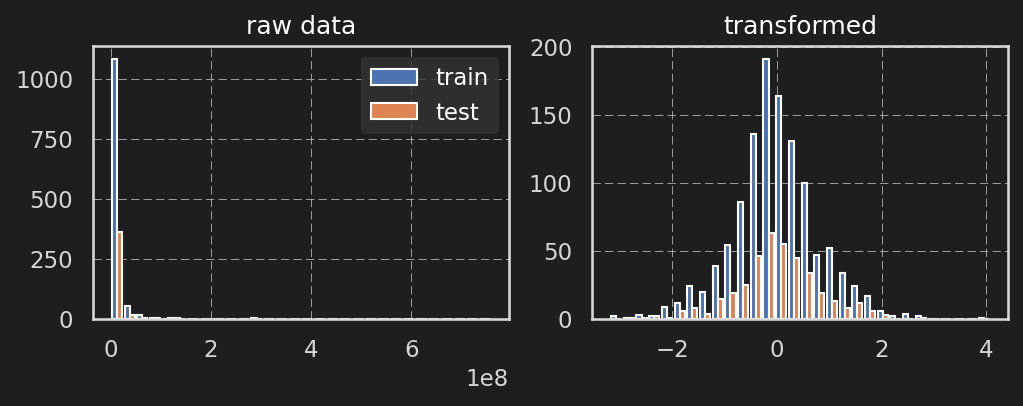

In [10]:
y2_train = y_transfomer_ref.get_y_pred( 'train' )
y2_test = y_transfomer_ref.get_y_pred( 'test' )
transformer = Transformer('log').fit( y2_train )

y_pred_min, y_pred_max = min( y2_train.min(), y2_test.min()), max( y2_train.max(), y2_test.max())

fig, axs = plt.subplots( ncols=2, figsize=(20*cm, 6*cm))
axs[0].hist( (y_transfomer_ref.get_y('train'), y_transfomer_ref.get_y('test')), bins=30, label=['train','test'] )
axs[0].set_title('raw data')
# axs[1].hist( , bins=30 )
axs[1].hist( (transformer.transform(y2_train),transformer.transform(y2_test)), bins=30 )
axs[1].set_title('transformed')
axs[0].legend()


In [11]:
if False:
    from sklearn.cluster import KMeans


    print(n_continuous)
    scaler_X = X_Scaler( n_scale_X ).fit( X )
    Xi = scaler_X.transform( X )
    Xi = np.hstack( (Xi, transformer.transform(y.values).reshape(-1,1)))
    sse = {}
    labels = {}
    for k in range(1, 12):
        kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto').fit(Xi)
        sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
        labels[k] = kmeans.labels_ # i mean of each element

    fig, ax = plt.subplots( figsize=(12*cm,8*cm))
    ax.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")

In [12]:
if False:
    labels_y = labels[3]
    X_train, X_test, y_train, y_test = model_selection.train_test_split( X, y, random_state=0, stratify=labels_y )
    y_train, y_test = y_train.values, y_test.values

    print('X', X.shape)
    print( 'X_train:', X_train.shape )

    print('Number of 0 in each colomn:')
    for i in range(X.shape[1]):
        prop_zeros_train = (X_train[:,i]==0).sum()/X_train.shape[0]
        prop_zeros_test = (X_test[:,i]==0).sum()/X_test.shape[0]
        print( '{:30}: train {:4.1%}, test {:4.1%}'.format( features_X[i], prop_zeros_train, prop_zeros_test) )

    dico_y = {'train':y_train, 'test':y_test}

***
# Definitions

Définition des modèles

In [13]:
modeles = {
    'dummy median': (dummy.DummyRegressor( ), {'strategy':['median']}),
    'elastic net':( linear_model.ElasticNet(random_state=0), 
                        {'l1_ratio':np.geomspace(0.5, 0.99, 10),
                        'alpha':np.logspace(-5, 1, 20)} ),
    'linear SVR': ( LinearSVR( dual=False ),
                        {'loss':['epsilon_insensitive', 'squared_epsilon_insensitive'],
                        'C':np.logspace(-5, 10, 20) } ),
    'kernel ridge polynomial':( kernel_ridge.KernelRidge(kernel='polynomial'),
                        {'alpha':np.logspace(-4, -2, 10),
                        'degree':[1,2,3,4],} ),
    'kernel ridge rbf':( kernel_ridge.KernelRidge(kernel='rbf'),
                        {'alpha':np.logspace(-6, 0, 10),
                        'gamma':np.logspace(-6, 0, 10),}),
    'kernel SVR rbf': ( SVR(kernel='rbf'),
                        {'C':np.logspace(-5, 4, 10),
                        'gamma':np.logspace(-5, -3, 10),} ),
    'random forest': ( RandomForestRegressor(),
                        {'n_estimators':[100, 200, 300, 400, 500],
                        'min_samples_split': [10, 20, 50],
                        'max_depth':[None, 5, 10],
                        'max_features': ['auto', 'sqrt'] #nombre de features observées pour chaque arbre
                        }),
    'light GBM': ( LGBMRegressor(),
                        {'n_estimators': [100, 200, 300, 400, 500],
                        'subsample': np.arange(0.1, 1.1, 0.1),
                        'learning_rate': [0.001, 0.01, 0.1, 1.0],
                        'max_depth': np.arange(2, 11, 2),} ),
}

# pour gagner en vitesse pour les premier essais
# _ = modeles.pop( 'kernel ridge rbf' )
# _ = modeles.pop( 'kernel SVR rbf' )
# _ = modeles.pop( 'random forest' )
# _ = modeles.pop( 'light GBM' )

Fonctions

In [14]:
def print_coefs( coefs, features ):
    n_features_0 = len( features )

    print('coefficients linear:')
    print(coefs[:n_features_0])

    if len( coefs ) > n_features_0:
        print('coefficients non-linear:')
        print(coefs[n_features_0:])

    print('linear coefs == 0 for :') #, np.array(features)[ coefs[:n_features_0+1] == 0. ])
    print('[', end='')
    for feature in np.array(features)[ coefs[:n_features_0] == 0. ]:
        print( f"'{feature}', ", end='')
    print(']')

    if len( coefs ) > n_features_0+1:
        print('non-linear coefs == 0 for :', np.array(features[1:])[ coefs[n_features_0+1:] == 0. ])

def histogram_per_coef( X, coefs, features ):
    y = (X @ coefs.reshape(-1,1)).ravel()
    for xi, coef, feature in zip( X.transpose(), coefs, features):
        fig, ax = plt.subplots( figsize=(12*cm,8*cm))
        ax.hist( xi*(coef*100)/y, bins=50 )
        ax.set_ylabel('count')
        ax.set_xlabel('influence sur la cible (%)')
        ax.set_title(feature)

def plot_results0( label, dico_results ):

    # argsort = y_test.argsort()
    # fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
    # ax.plot( y_test[argsort], 'r', label='data' )
    # ax.plot( y_pred[argsort], 'bo', markersize=2, label=label )
    # ax.legend()
    # ax.set_xlabel('sample')

    # fig, axs = plt.subplots( ncols=2, nrows=2, figsize=(20*cm,20*cm) )
    n0, ncb, nhist = 4, 0,2
    width = 20*cm
    fig = plt.figure( figsize=(width,width*(n0+nhist)/(2*n0+ncb)) )
    gs = fig.add_gridspec( n0+nhist, 2*n0+ncb, hspace=2 )

    fig.suptitle( label )

    for i, dataset in enumerate( ['train', 'test'] ):
        y_pred = dico_results[label][ f'y_pred {dataset}' ]
        y = y_transfomer_ref.get_y(dataset)
        # ax = axs[0][i]
        i0,i1 = i*(n0+ncb),i*(n0+ncb)+n0
        ax = fig.add_subplot(gs[:n0, i0:i1])

        ax.set_title( f'{dataset} set')
        ax.set_ylabel( 'prediction ' )
        ax.set_xlabel( 'target' )
        # ax.loglog( y, y_pred, 'bo', markersize=2 )
        ax.set_yscale('log')
        ax.set_xscale('log')
        scttr = ax.scatter( y, y_pred, s=2, c= y_transfomer_ref.get_y_pred(dataset), vmin=y_pred_min, vmax=y_pred_max )
        if dataset == 'train':
            i0,i1 = n0,n0+ncb
            # axcb = fig.add_subplot(gs[:n0, i0:i1] )
            cax = fig.add_axes([0.25, 0.48, 0.22, 0.015])
            # cb = plt.colorbar( scttr, cax=axcb, fraction=0.2 )
            cb = fig.colorbar( scttr, ax=ax, cax=cax, orientation='horizontal', label='Energy per GFA (kbtu/sf)', alpha=0.7 )
            cb.ax.tick_params(labelsize=7)
            cb.set_label( 'Energy per GFA (kbtu/sf)', size=7)
            # help( fig.colorbar )
        xy_optim = [y.min(), y.max()]
        ax.loglog( xy_optim, xy_optim, 'r', label='optimal fit' )
        # ax.legend()
        # ax = axs[1][i]
        ax = fig.add_subplot(gs[n0:, i*(n0+ncb):i*(n0+ncb)+n0])

        # ax.hist( y_pred-y, bins=60 )
        # ax.set_xlabel('Residual')
        ax.hist( 100*(y_pred-y)/np.abs(y), bins=60 )
        ax.set_xlabel('Residual (%)')
    # fig.tight_layout()
    gs.tight_layout(fig)
    return

def model_to_results( name, model, training_time, dico_results ):
    dico_results[name] = {'y_pred test': model.predict(dico_X['test'], 'test' ),
                        'y_pred train': model.predict(dico_X['train'], 'train' ),
                        'training time': training_time,
                        'model':model }
    return

def results_to_df( dico_results ):
    scores = {
        'RMSE': lambda y_true,y_pred: np.sqrt(metrics.mean_squared_error(y_true,y_pred)),
        'R2 score': metrics.r2_score,
        'MAPE': metrics.mean_absolute_percentage_error,
        # 'MSLE':metrics.mean_squared_log_error,
        }
    # index = pd.MultiIndex.from_tuples( [('', 'training time (sec.)')]
    #                                     + [('train',score) for score in scores]
    #                                     + [('test',score) for score in scores] )
    
    index = pd.MultiIndex.from_tuples( [('', 'training time (sec.)')]
                    + [(score,dataset) for score in scores for dataset in ['train', 'test'] ] )
    

    df_results = pd.DataFrame( index=index )
    for (name, results) in dico_results.items():
        df_results[name] = [results['training time']] \
            + [ score(y_transfomer_ref.get_y(dataset), dico_results[name][ f'y_pred {dataset}']) for score in scores.values() for dataset in ['train', 'test'] ]
                        # + [ score(y_train_transformed, y_pred_train) for score in scores.values()] \
                        # + [ score(y_test_transformed, y_pred_test) for score in scores.values()]
    return df_results

def print_results( dico_results ):
    display( results_to_df( dico_results ).round(2) )
    print( f"{'modèle':30} | Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement")
    for name in modeles:
        model = dico_results[name]['model']
        print('{:30} |'.format(name), ', '.join([ f'{param}: {value}' for param,value in model.best_params_.items() ]) )
        # print('\n\n|' + 20*'-' + '|\nModèle : {:}'.format(name) )
        # print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
        # print(model.best_params_)
        # plot_results( name, dico_results )
    return

def plot_results( dico_results ):
    for name in modeles:
        model = dico_results[name]['model']
        plot_results0( name, dico_results )
        # break
    return

In [15]:
def train_modeles( y_transformer, score='r2' ):
    dico_results = {}
    for name, (model, param_grid) in modeles.items():
        model = train_model( name, model, param_grid, y_transformer, dico_results, score )
    return dico_results

def train_model( model_name, model, param_grid, y_transformer, dico_results, score='r2' ): 
    # Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
    modelCV = model_selection.GridSearchCV(
        model, # modèle
        param_grid,     # hyperparamètres à tester
        cv=5,           # nombre de folds de validation croisée
        scoring=score,   # score à optimiser
        n_jobs=-1
    )

    t0 = time.time()
    # modelCV.fit(dico_X['train'], dico_y['train'] )
    modelCV = Model_With_Y_Transform( modelCV, y_transformer, y_transfomer_ref ).fit( dico_X['train'], dataset='train' )

    model_to_results( model_name, modelCV, time.time()-t0, dico_results )

    return modelCV


# def print_y_describe():
#     print('y:')
#     columns = pd.MultiIndex.from_tuples( [('raw', 'train'), ('raw', 'test'), 
#                                         ('transformed', 'train'), ('transformed', 'test')] )
#     describe = pd.Series(y_train).describe()
#     tmp = pd.DataFrame( index=describe.index, columns=columns )

#     tmp[ 'raw', 'train' ] = describe
#     describe = pd.Series(y_test).describe()
#     tmp[ 'raw', 'test' ] = describe
#     describe = pd.Series(dico_y['train']).describe()
#     tmp[ 'transformed', 'train' ] = describe
#     describe = pd.Series(dico_y['test']).describe()
#     tmp[ 'transformed', 'test' ] = describe

#     display( tmp.round(2).T )
#     return

***
# Modélisations

## Calculs

In [16]:
def save_models( models, path_save ):
    for name, results in models.items():
        name = name.replace(' ', '_')
        # print(results.keys())
        # print(models.keys())
        model = results['model']
        tmp = os.path.join( path_save, name, '' ) 
        try: 
            os.makedirs(tmp) 
        except OSError as error: 
            print(error)
        # tmp = f'{path_save}/{name}/'.replace('//','/')
        model.save( tmp )
        # print( tmp)
        pickle.dump( {key:val for key, val in results.items() if key != 'model'}, open( tmp + 'dict.pkl', 'wb' ) )
    return 

def load_models( path_save ):
    models = {}
    path_save = os.path.join(path_save, '')
    # print( 'path_save:', path_save )
    # print( os.listdir( path_save ))
    for name in os.listdir( path_save ):
        # print('name:', name)
        tmp = os.path.join( path_save, name, '' )
        results = pickle.load( open( tmp + 'dict.pkl', 'rb' ) )
        results['model'] = Model_With_Y_Transform( filepath=tmp )
        models[name.replace('_', ' ')] = results
        # print('models:', models.keys())
    return models

In [17]:
path_save = './data/models/'

scaler = X_Scaler( n_scale_X ).fit( X_train )
dico_X_scaled = scaler.scale_train_and_test( X_train, X_test )
dico_X = {'train':X_train, 'test':X_test}

dico_data = {0:dico_X, 1:dico_X_scaled, 2:dico_X, 3:dico_X_scaled}

if False:
    results_0 = train_modeles( Transformer('identity'), 'neg_mean_absolute_percentage_error' )
    save_models( results_0, os.path.join( path_save, 'raw', '') )
    
    results_2 = train_modeles( Transformer('log'), 'neg_mean_absolute_error' )
    save_models( results_2, os.path.join( path_save, 'ylog', '') )

    dico_X = dico_X_scaled
    results_1 = train_modeles( Transformer('identity'), 'neg_mean_absolute_percentage_error' )
    save_models( results_1, os.path.join( path_save, 'Xscaled', '') )

    results_3 = train_modeles( Transformer('log'), 'neg_mean_absolute_error' )
    save_models( results_3, os.path.join( path_save, 'Xscaled_ylog', '') )
else:
    results_0 = load_models( os.path.join( path_save, 'raw', '') )
    results_1 = load_models( os.path.join( path_save, 'Xscaled', '') )
    results_2 = load_models( os.path.join( path_save, 'ylog', '') )
    results_3 = load_models( os.path.join( path_save, 'Xscaled_ylog', '') )

In [18]:
print('Raw:')
print_results( results_0 )

print('\n\n|' + '-'*20 + '|\n')
print('X scaled:')
print_results( results_1 )

print('\n\n|' + '-'*20 + '|\n')
print('y log:')
print_results( results_2 )

print('\n\n|' + '-'*20 + '|\n')
print('X scaled & y log:')
print_results( results_3 )
# plot_results( results_0 )

Raw:


dummy median  elastic net   linear SVR  \
         training time (sec.)          1.05         1.66         0.23   
RMSE     train                  15090487.87  10770122.02  11113416.57   
         test                   29288172.15  40769193.27  35633979.91   
R2 score train                         0.39         0.69         0.67   
         test                          0.64         0.31         0.47   
MAPE     train                         0.86         0.80         0.81   
         test                          0.97         0.96         0.98   

                               kernel ridge polynomial  kernel ridge rbf  \
         training time (sec.)                    17.51             12.46   
RMSE     train                             10647839.61        9781057.04   
         test                              39594631.12       49725787.94   
R2 score train                                    0.70              0.74   
         test                                     0.34             -0.03   
MAPE     train                                    0.79              0.39   
         test                                     0.95              0.73   

                               kernel SVR rbf  random forest    light GBM  
         training time (sec.)            5.06         103.12       117.19  
RMSE     train                    11432862.14     4859070.16   8129068.60  
         test                     23901011.54    18720740.57  26975965.64  
R2 score train                           0.65           0.94         0.82  
         test                            0.76           0.85         0.70  
MAPE     train                           0.60           0.46         0.67  
         test                            0.75           0.95         0.97

modèle                         | Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement
dummy median                   | strategy: median
elastic net                    | alpha: 0.01438449888287663, l1_ratio: 0.99
linear SVR                     | C: 127.42749857031347, loss: squared_epsilon_insensitive
kernel ridge polynomial        | alpha: 0.000774263682681127, degree: 1
kernel ridge rbf               | alpha: 1.0, gamma: 1.0
kernel SVR rbf                 | C: 10000.0, gamma: 0.00035938136638046257
random forest                  | max_depth: None, max_features: auto, min_samples_split: 10, n_estimators: 500
light GBM                      | learning_rate: 0.01, max_depth: 10, n_estimators: 400, subsample: 0.1


|--------------------|

X scaled:


dummy median  elastic net   linear SVR  \
         training time (sec.)          0.01         2.02         0.21   
RMSE     train                  15090487.87  10590926.91  10591631.47   
         test                   29288172.15  39610516.25  39958648.73   
R2 score train                         0.39         0.70         0.70   
         test                          0.64         0.34         0.33   
MAPE     train                         0.86         0.80         0.80   
         test                          0.97         0.95         0.95   

                               kernel ridge polynomial  kernel ridge rbf  \
         training time (sec.)                     3.84              9.90   
RMSE     train                             10593181.27        9081823.36   
         test                              39604163.76       48011954.81   
R2 score train                                    0.70              0.78   
         test                                     0.34              0.04   
MAPE     train                                    0.80              0.48   
         test                                     0.95              0.87   

                               kernel SVR rbf  random forest    light GBM  
         training time (sec.)            6.50         108.91       123.63  
RMSE     train                    11370596.78     5223467.49   8153931.32  
         test                     25433024.66    22685889.51  26925986.13  
R2 score train                           0.65           0.93         0.82  
         test                            0.73           0.78         0.70  
MAPE     train                           0.61           0.46         0.67  
         test                            0.78           0.95         0.97

modèle                         | Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement
dummy median                   | strategy: median
elastic net                    | alpha: 1e-05, l1_ratio: 0.99
linear SVR                     | C: 10000000000.0, loss: squared_epsilon_insensitive
kernel ridge polynomial        | alpha: 0.0001, degree: 1
kernel ridge rbf               | alpha: 1.0, gamma: 1.0
kernel SVR rbf                 | C: 10000.0, gamma: 0.00035938136638046257
random forest                  | max_depth: None, max_features: auto, min_samples_split: 10, n_estimators: 100
light GBM                      | learning_rate: 0.01, max_depth: 10, n_estimators: 400, subsample: 0.1


|--------------------|

y log:


dummy median  elastic net   linear SVR  \
         training time (sec.)          0.01         0.95         0.22   
RMSE     train                  15090487.87  10224750.12  10354818.61   
         test                   29288172.15  13659136.71  14124742.46   
R2 score train                         0.39         0.72         0.71   
         test                          0.64         0.92         0.92   
MAPE     train                         0.86         0.61         0.61   
         test                          0.97         0.81         0.81   

                               kernel ridge polynomial  kernel ridge rbf  \
         training time (sec.)             1.383000e+01              9.77   
RMSE     train                            6.590975e+06        9936086.35   
         test                             4.431737e+08       14867624.41   
R2 score train                            8.800000e-01              0.74   
         test                            -8.110000e+01              0.91   
MAPE     train                            5.200000e-01              0.60   
         test                             2.100000e+00              0.82   

                               kernel SVR rbf  random forest    light GBM  
         training time (sec.)           17.56          90.93       137.72  
RMSE     train                     9159818.58     6561683.25   9773094.58  
         test                     55244480.17    36247627.83  36144548.87  
R2 score train                           0.78           0.88         0.74  
         test                           -0.28           0.45         0.45  
MAPE     train                           0.60           0.28         0.42  
         test                            0.80           0.69         0.72

modèle                         | Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement
dummy median                   | strategy: median
elastic net                    | alpha: 0.0007847599703514606, l1_ratio: 0.5
linear SVR                     | C: 0.5455594781168515, loss: squared_epsilon_insensitive
kernel ridge polynomial        | alpha: 0.01, degree: 2
kernel ridge rbf               | alpha: 1e-06, gamma: 1e-06
kernel SVR rbf                 | C: 10000.0, gamma: 4.641588833612782e-05
random forest                  | max_depth: None, max_features: auto, min_samples_split: 10, n_estimators: 500
light GBM                      | learning_rate: 0.01, max_depth: 10, n_estimators: 300, subsample: 0.1


|--------------------|

X scaled & y log:


dummy median  elastic net   linear SVR  \
         training time (sec.)          0.01         0.97         0.34   
RMSE     train                  15090487.87  10184945.23  10341151.42   
         test                   29288172.15  13802364.74  14296731.51   
R2 score train                         0.39         0.72         0.71   
         test                          0.64         0.92         0.91   
MAPE     train                         0.86         0.61         0.61   
         test                          0.97         0.82         0.82   

                               kernel ridge polynomial  kernel ridge rbf  \
         training time (sec.)                     3.78             10.82   
RMSE     train                              6723672.56        8035998.70   
         test                              40845490.31       16683088.26   
R2 score train                                    0.88              0.83   
         test                                     0.30              0.88   
MAPE     train                                    0.50              0.53   
         test                                     0.82              0.75   

                               kernel SVR rbf  random forest    light GBM  
         training time (sec.)            7.18          96.58       142.96  
RMSE     train                     7813343.92     6350062.75   9750705.96  
         test                     19038703.11    35994663.65  36073055.77  
R2 score train                           0.84           0.89         0.75  
         test                            0.85           0.46         0.46  
MAPE     train                           0.56           0.29         0.42  
         test                            0.81           0.68         0.72

modèle                         | Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement
dummy median                   | strategy: median
elastic net                    | alpha: 0.0007847599703514606, l1_ratio: 0.5
linear SVR                     | C: 0.5455594781168515, loss: squared_epsilon_insensitive
kernel ridge polynomial        | alpha: 0.01, degree: 2
kernel ridge rbf               | alpha: 0.01, gamma: 0.01
kernel SVR rbf                 | C: 10000.0, gamma: 0.0005994842503189409
random forest                  | max_depth: None, max_features: auto, min_samples_split: 10, n_estimators: 200
light GBM                      | learning_rate: 0.01, max_depth: 10, n_estimators: 300, subsample: 0.1


## Récupération du meilleur résultat pour chaque modèle

dummy median  elastic net   linear SVR  \
         training time (sec.)          0.01         0.95         0.22   
RMSE     train                  15090487.87  10224750.12  10354818.61   
         test                   29288172.15  13659136.71  14124742.46   
R2 score train                         0.39         0.72         0.71   
         test                          0.64         0.92         0.92   
MAPE     train                         0.86         0.61         0.61   
         test                          0.97         0.81         0.81   

                               kernel ridge polynomial  kernel ridge rbf  \
         training time (sec.)                    17.51              9.77   
RMSE     train                             10647839.61        9936086.35   
         test                              39594631.12       14867624.41   
R2 score train                                    0.70              0.74   
         test                                     0.34              0.91   
MAPE     train                                    0.79              0.60   
         test                                     0.95              0.82   

                               kernel SVR rbf  random forest    light GBM  
         training time (sec.)            7.18         103.12       123.63  
RMSE     train                     7813343.92     4859070.16   8153931.32  
         test                     19038703.11    18720740.57  26925986.13  
R2 score train                           0.84           0.94         0.82  
         test                            0.85           0.85         0.70  
MAPE     train                           0.56           0.46         0.67  
         test                            0.81           0.95         0.97

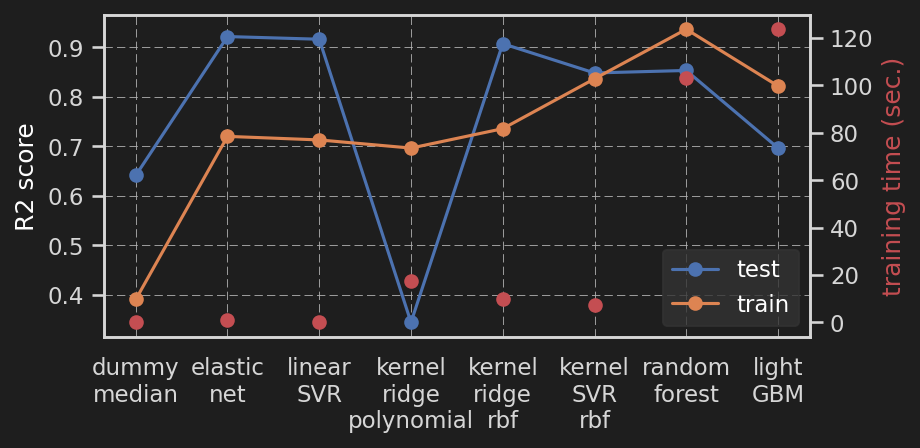

In [20]:
all_results = [results_0, results_1, results_2, results_3 ]
all_df_results = [ results_to_df( results )  for results in all_results ]
best_results = {}
best_models = pd.DataFrame( index=all_df_results[0].index )
inds_best = {}
for name in results_0:
    # recherche du meilleur résultat pour le R2 sur le test set
    i_best = np.argmax([ all_df_results[i][name][ ('R2 score', 'test') ] for i in range(4) ] )
    inds_best[name] = i_best
    best_models[name] = all_df_results[i_best][name]
    best_results[name] = all_results[i_best][name]

display( best_models.round(2) )
names = [name.replace(' ', '\n') for name in results_0]

fig, ax = plt.subplots( figsize=(16*cm, 8*cm))

ax.plot( names, best_models.loc[ ('R2 score', 'test') , : ] , 'o-', label='test')
ax.plot( names, best_models.loc[ ('R2 score', 'train') , : ] , 'o-', label='train')
ax.legend()
ax.set_ylabel( 'R2 score' )

ax = ax.twinx()
ax.plot( names, best_models.loc[ ('', 'training time (sec.)') , : ] , 'ro', label='train')
ax.set_ylabel( 'training time (sec.)', color='r' )
ax.grid( visible=False )

fig.tight_layout()

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


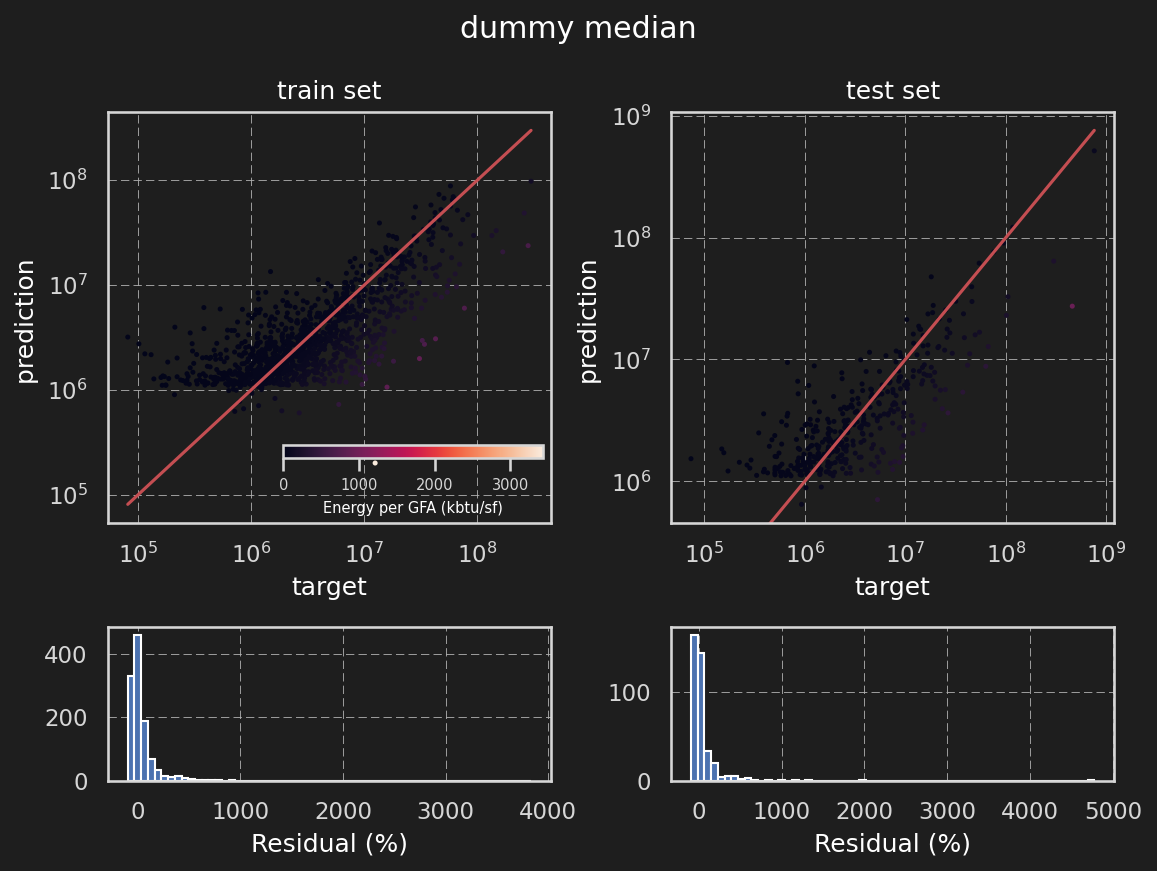

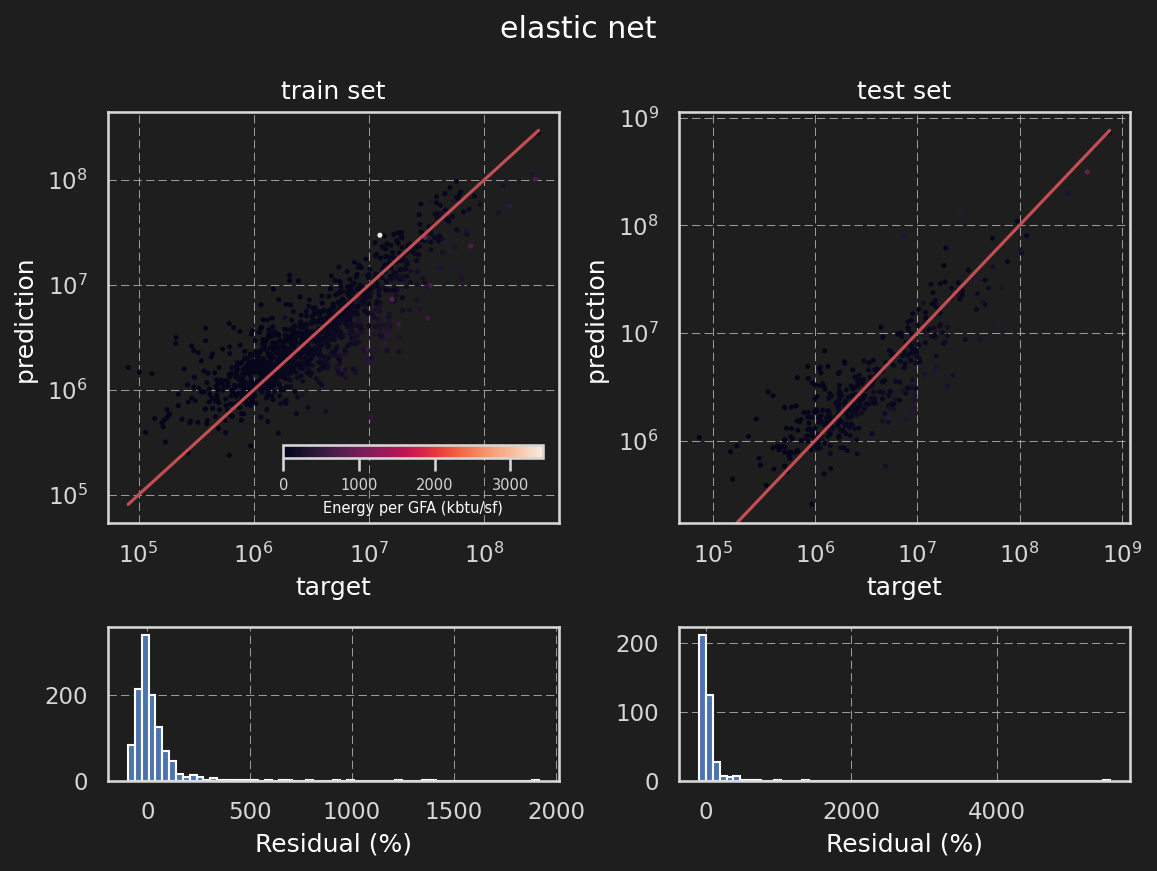

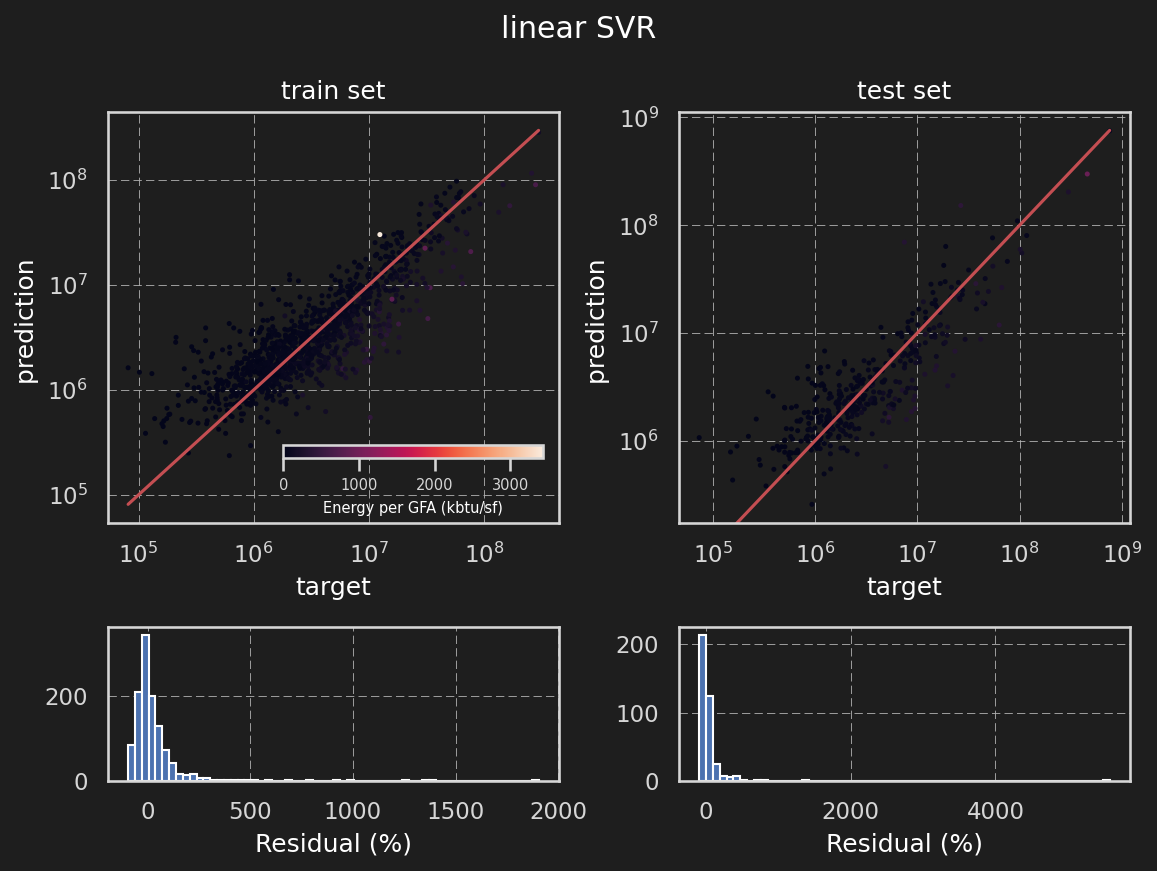

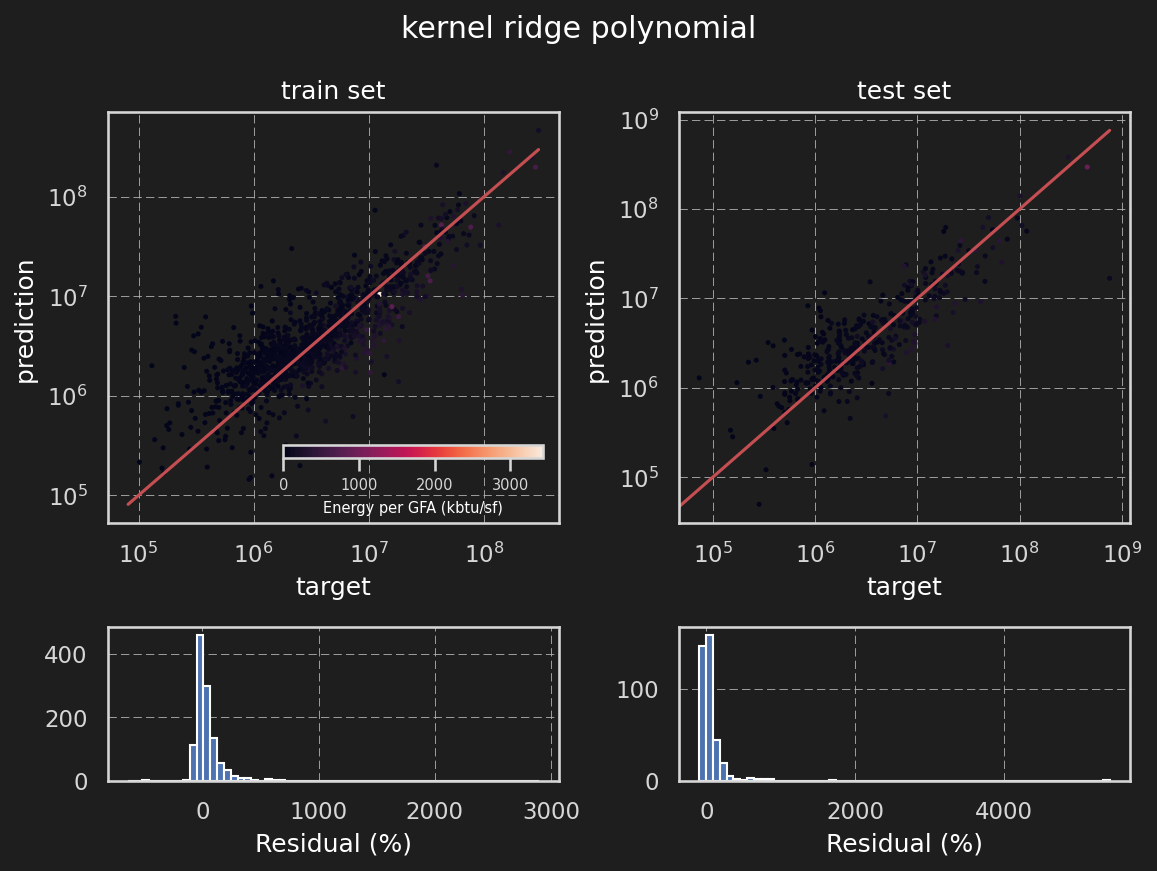

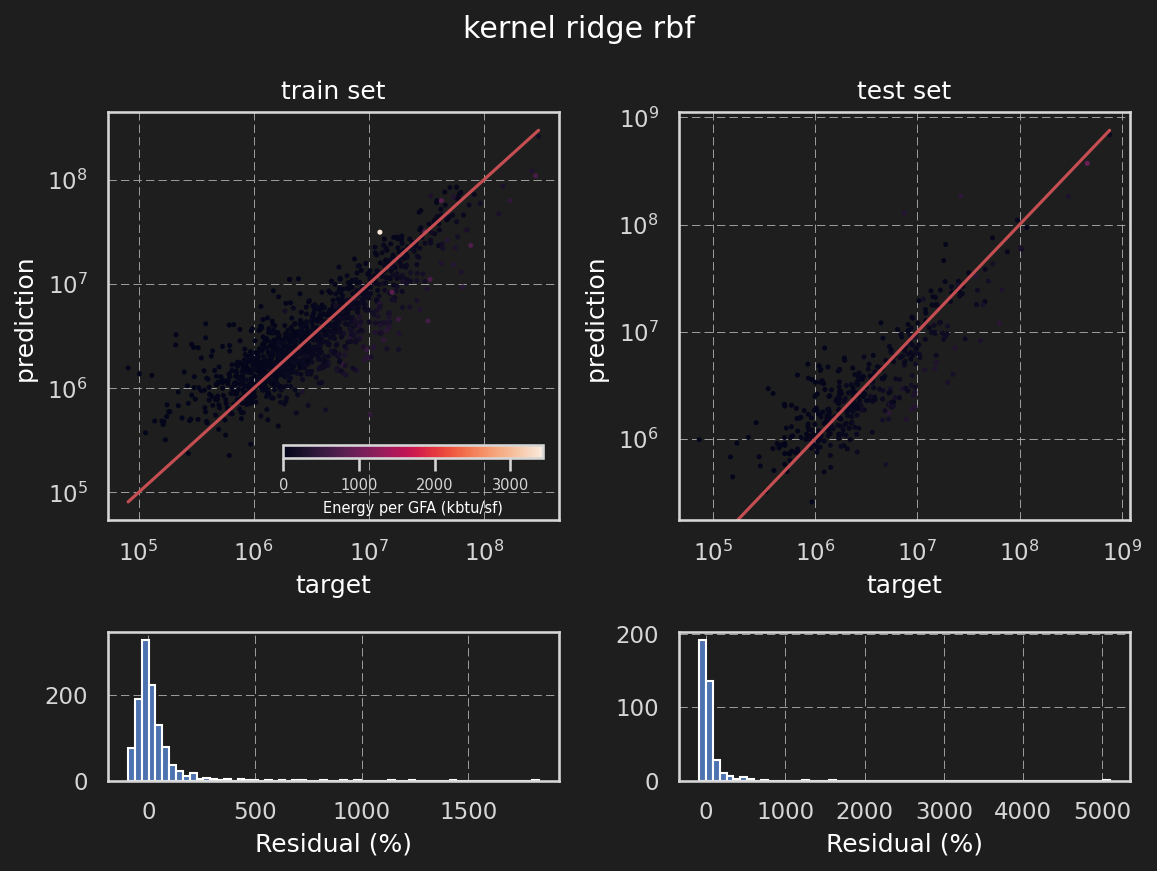

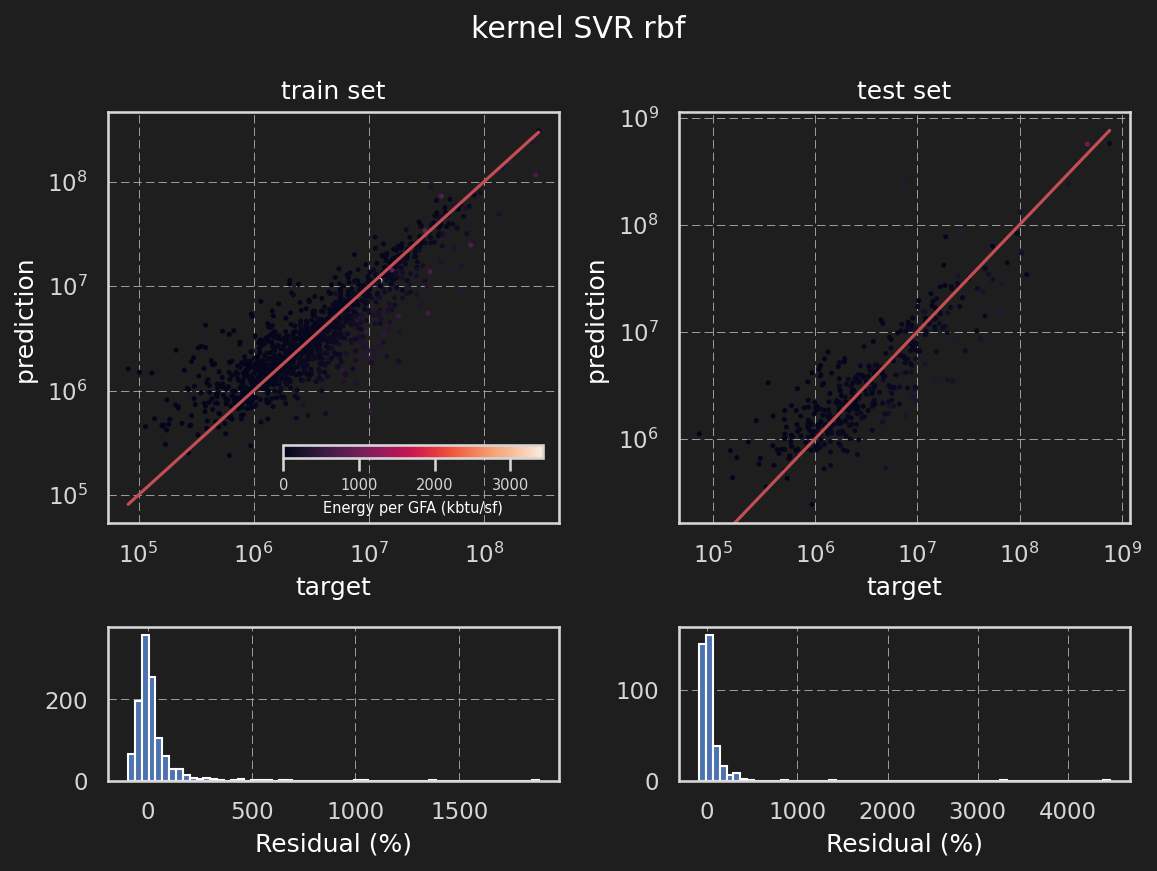

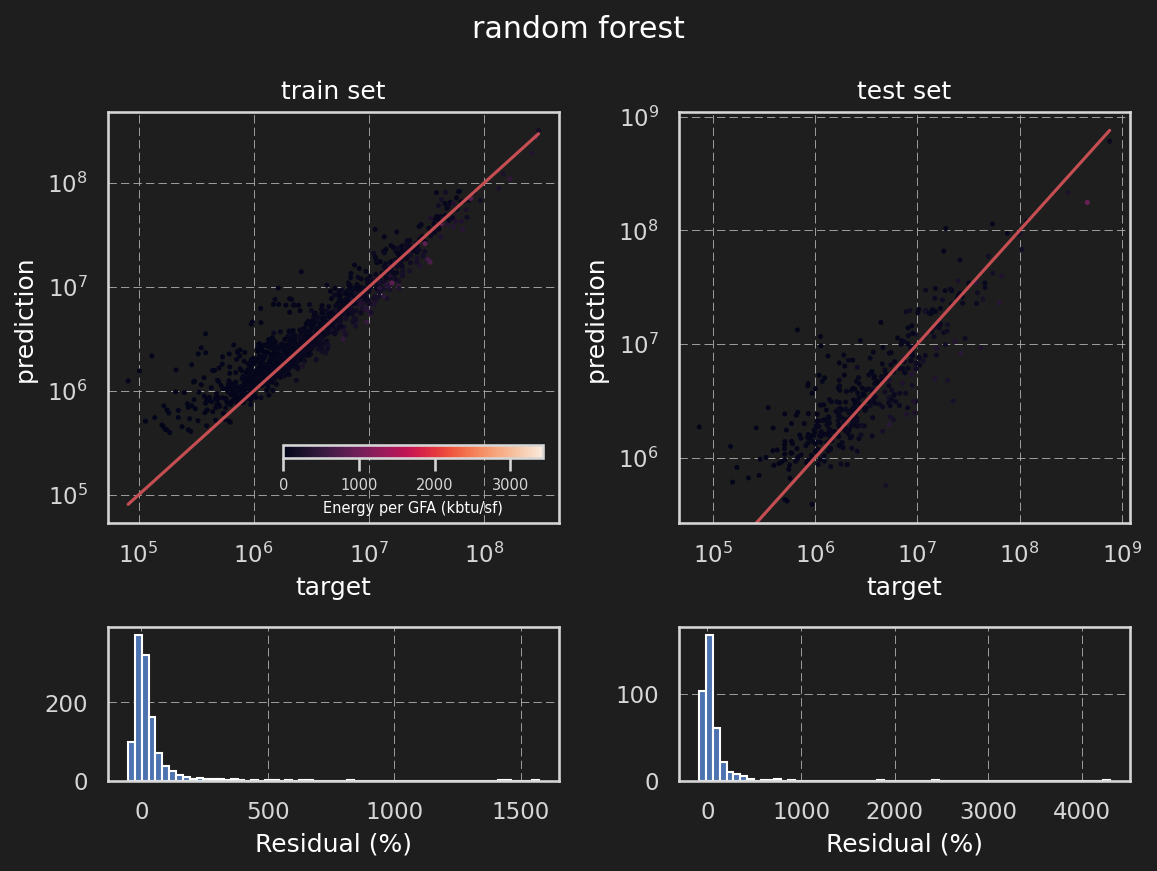

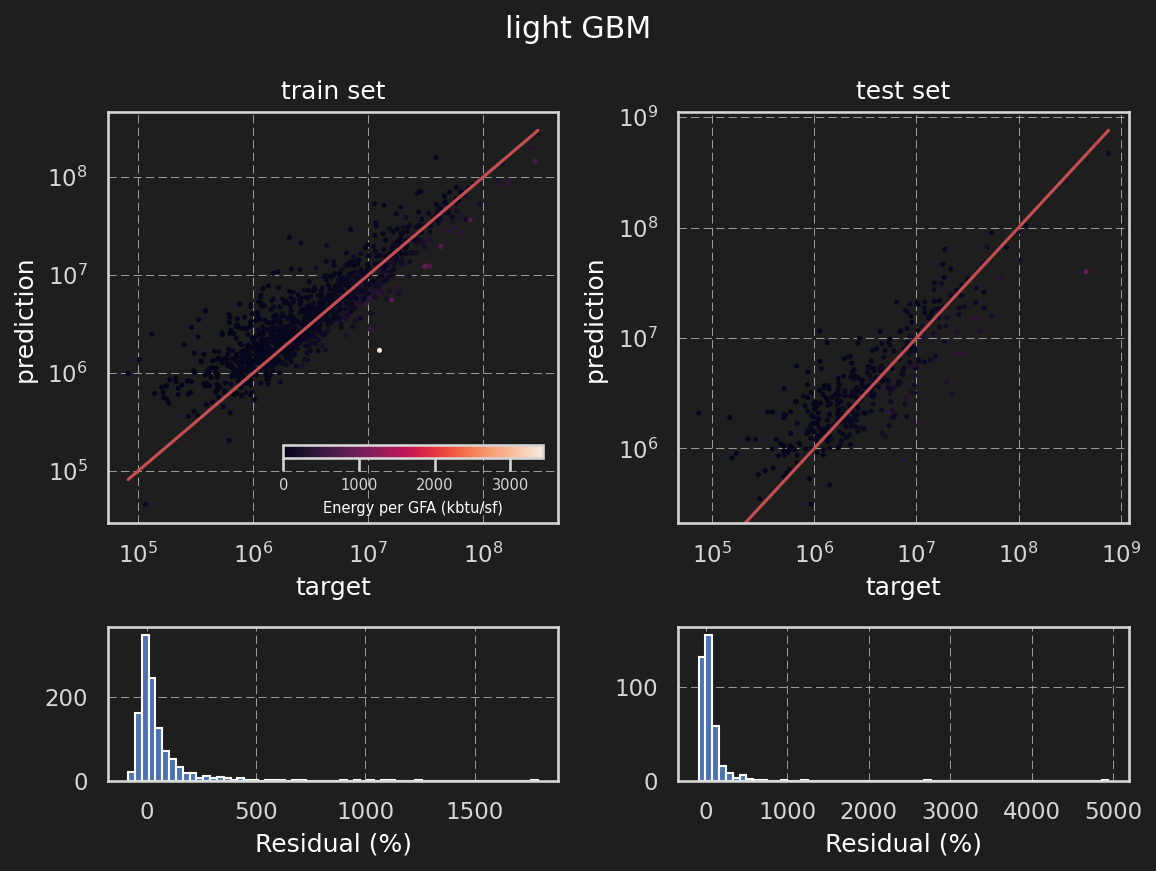

In [21]:
plot_results( best_results )

## SHAP
Code inspiré du notebook "interpretability_Revisited_LIME_and_SHAP_in_prose_and_code.ipynb" (ressources du projet)

In [126]:
y_pred = y_transfomer_ref.get_y_pred( 'train' )
i_entry = y_pred.argmax()
display( pd.Series(y_pred).describe() )

print('entry name:', df_annexe['PropertyName'].iloc[ indices_train[i_entry]])

display( df.iloc[ indices_train[i_entry], : ])

print('y target max (kBtu/sf):', y_pred[i_entry])


count    1163.000000
mean       83.133939
std       130.523716
min         1.407067
25%        36.700921
50%        55.331505
75%        89.131084
max      3434.854960
dtype: float64

entry name: ballard center


AgeOfBuilding(s)                                50.000000
Latitude                                        47.698750
Longitude                                     -122.367250
NumberofBuildings                                1.000000
NumberofFloors                                   2.000000
GFA_per_floor                                 1818.000000
sqrt_GFA_per_floor                              42.638011
prop_SteamUse                                    0.000000
prop_Electricity                                 0.293148
prop_NaturalGas                                  0.706852
ohe0 data center                                 0.000000
ohe0 education                                   0.000000
ohe0 entertainment - public assembly             0.000000
ohe0 industrial                                  0.000000
ohe0 lifestyle center                            0.000000
ohe0 medical                                     9.900990
ohe0 medical office                              0.000000
ohe0 office   

y target max (kBtu/sf): 3434.8549603293036


In [127]:
def get_kernel_shap_explainer(model, background_data, train_data):  
  shap_explainer = shap.KernelExplainer(model.predict, background_data)   
  return shap_explainer


data_subsample = 100
name = 'kernel SVR rbf'
i = inds_best[name]

model = all_results[i][name]['model'].model.best_estimator_
dico_X = dico_data[i]


sampled_scaled_train_data = shap.sample(dico_X['train'], data_subsample) # subsample background data to make things faster
shap_explainer = get_kernel_shap_explainer( model, sampled_scaled_train_data, dico_X['train'])
shap_values = shap_explainer.shap_values(dico_X['train'][i_entry:i_entry+1],  l1_reg="aic")

100%|██████████| 1/1 [00:09<00:00,  9.80s/it]


In [128]:
shap.force_plot(shap_explainer.expected_value, np.around(shap_values[0],2), dico_X['train'][i_entry], feature_names=features_X )

## Feature importance

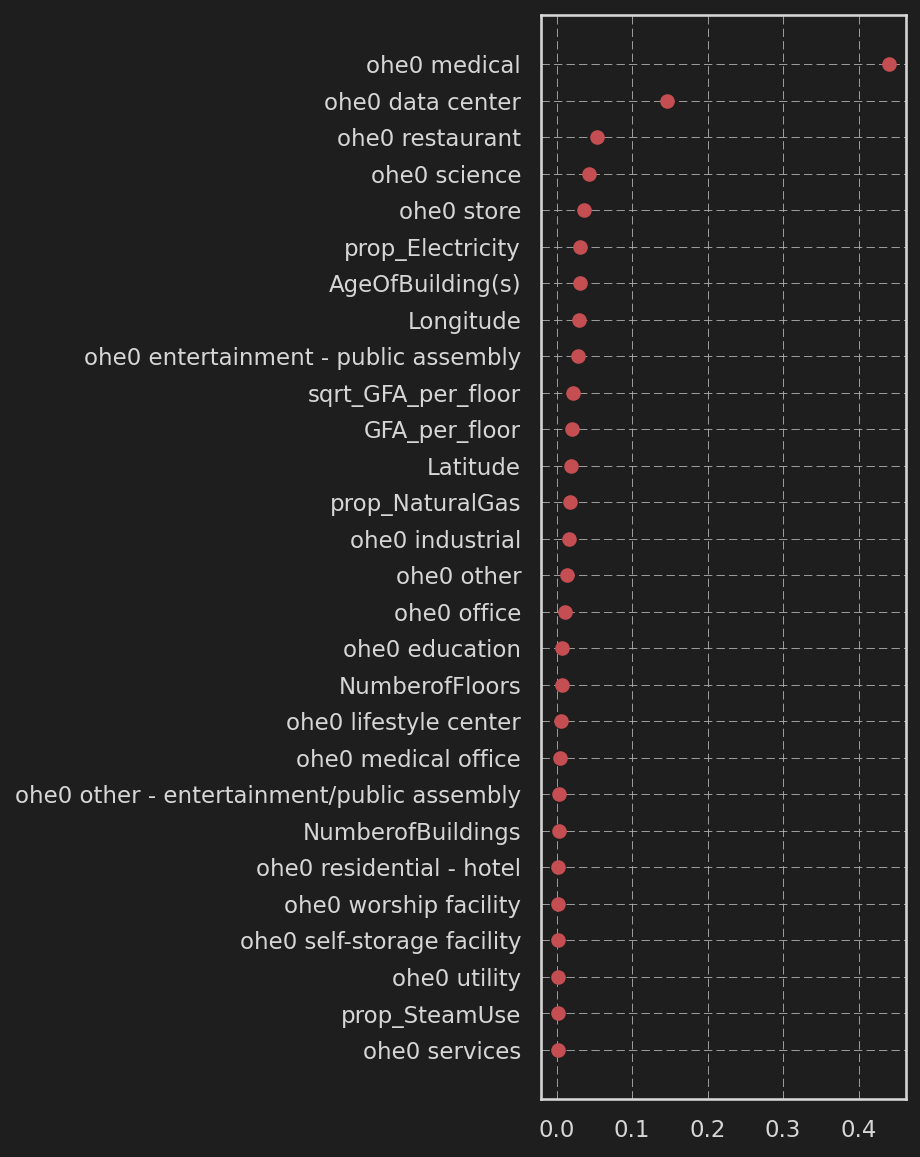

In [129]:
name = 'random forest'
i = inds_best[name]
# display( i )


model = all_results[i][name]['model'].model.best_estimator_

fig, ax = plt.subplots(figsize=(16*cm,20*cm))
argsort = model.feature_importances_.argsort()
ax.plot( model.feature_importances_[argsort], np.array(features_X)[argsort], 'ro' )
fig.tight_layout()

## Essai avec l'EnergySTARSCORE
Pour le modèle sélectionné (kernel SVR rbf), les résultats sont dégradés. Un point important à noter est qu'il y a moins de données

In [130]:
name = 'kernel SVR rbf'
i = inds_best[name]

X2 = np.hstack( (df_annexe['ENERGYSTARScore'].values.reshape(-1,1), X) )

isna = np.isnan( X2[:,0] )
X2 = X2[~isna]

print('X2:', X2.shape)
print('isna sum:', isna.sum())
# i > 1 -> log y

indices2 = np.arange( X2.shape[0] )

X_train, X_test, indices_train, indices_test = model_selection.train_test_split( X2, indices2, random_state=0,
        stratify=preprocessing.KBinsDiscretizer( n_bins=12, encode='ordinal').fit_transform( y_transformed[~isna].reshape(-1,1) ).ravel() )

y_transfomer_ref = Y_Transformer_Ref( y.values[~isna], GFA_ref.values[~isna], indices_train, indices_test )

dico_X = {'train':X_train, 'test':X_test}
if i %2 == 1: # -> scale X
    scaler = X_Scaler( n_scale_X+1 ).fit( X_train )
    dico_X = {'train':scaler.transform( X_train ), 'test':scaler.transform(X_test) }


lin_log = 'identity' if i < 2 else 'log'
score = 'neg_mean_absolute_percentage_error' if i < 2 else 'neg_mean_absolute_error'

modeles_0 = modeles
modeles = {name:modeles[name]}

results = train_modeles( Transformer(lin_log), score )
print_results( results )

X2: (1002, 29)
isna sum: 549


kernel SVR rbf
         training time (sec.)            4.11
RMSE     train                    15655050.18
         test                     11115327.40
R2 score train                           0.71
         test                            0.41
MAPE     train                           0.34
         test                            0.40

modèle                         | Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement
kernel SVR rbf                 | C: 10000.0, gamma: 0.001
